1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [27]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2023-11-16 21:42:40--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2023-11-16 21:42:40--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc37fd4bceb1070e7f5df7d4f178.dl.dropboxusercontent.com/cd/0/inline/CHqgDYtmojskPvW1YE67ePq0bugcA1Dk3aCT2WdglmfSh2vcf3szPjV-fuVXN8kko9KYX4FXYkhq93fW_gV803QDkVRoTTPtw7eNHdrT1ieOh9g7iRwTvlhPL2S00cVqGF8/file# [following]
--2023-11-16 21:42:41--  https://uc37fd4bceb1070e7f5df7d4f178.dl.dropboxusercontent.com/cd/0/inline/CHqgDYtmojskPvW1YE67ePq0bugcA1Dk3aCT2WdglmfSh2vcf3szPjV-fuVXN8kko9KYX4FXYkhq93fW_gV803QDkVRoTTPtw7eNHdrT1ieOh9g7iR

In [43]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [29]:
# set filename (path on colab)
file_name='/content/data/data_000637.txt'
# read the file
data=pd.read_csv(file_name)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [44]:
x = np.amax(data['BX_COUNTER'])
x

3563

3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [45]:
offset = data['ORBIT_CNT'][0] * x * 25 + data['BX_COUNTER'][0] * 25 + data['TDC_MEAS'][0] * 25 / 30
data['TIME_ns'] = data['ORBIT_CNT'] * x * 25 + data['BX_COUNTER'] * 25 + data['TDC_MEAS'] * 25 / 30 - offset
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_ns
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.801410e+08
1310716,1,1,4,3869211171,763,11,9.801410e+08
1310717,1,0,64,3869211171,764,0,9.801410e+08
1310718,1,0,139,3869211171,769,0,9.801412e+08


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [46]:

startTime = dt.datetime.now()
start = np.amin(data['ORBIT_CNT'] * x * 25 + data['BX_COUNTER'] * 25 + data['TDC_MEAS'] * 25 / 30)
stop = np.amax(data['ORBIT_CNT'] * x * 25 + data['BX_COUNTER'] * 25 + data['TDC_MEAS'] * 25 / 30)
finishTime = dt.datetime.now()

time = stop - start
print('Time (Max - Min of dataset):', time * 1e-9, 's')

readingTime = finishTime - startTime
print("Time took to read the whole dataset:", readingTime)

Time (Max - Min of dataset): 0.9801411533125001 s
Time took to read the whole dataset: 0:00:00.062461


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [47]:
noisy_channels = data.groupby('TDC_CHANNEL')['TDC_MEAS'].count().sort_values(ascending = False)
noisy_channels.iloc[0:3]

TDC_CHANNEL
139    108059
64      66020
63      64642
Name: TDC_MEAS, dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [48]:
count = data['ORBIT_CNT'].unique().shape[0]
print("The number of non-empty orbits: " + str(count))

The number of non-empty orbits: 11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [49]:
print("Unique orbits with TDC_CHANNEL=139:", data[data['TDC_CHANNEL'] == 139]['ORBIT_CNT'].unique().shape[0])

Unique orbits with TDC_CHANNEL=139: 10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [50]:
FPGA0 = data[data['FPGA'] == 0].groupby('TDC_CHANNEL')[['TDC_MEAS']].count()
FPGA0

,TDC_MEAS
TDC_CHANNEL,
1,1215
2,1602
3,1493
4,2352
5,1432
...,...
129,2
130,33
137,32


In [51]:
FPGA1 = data[data['FPGA'] == 1].groupby('TDC_CHANNEL')[['TDC_MEAS']].count()
FPGA1

,TDC_MEAS
TDC_CHANNEL,
1,28438
2,32669
3,21970
4,26403
5,15003
...,...
129,35
130,38
137,36


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

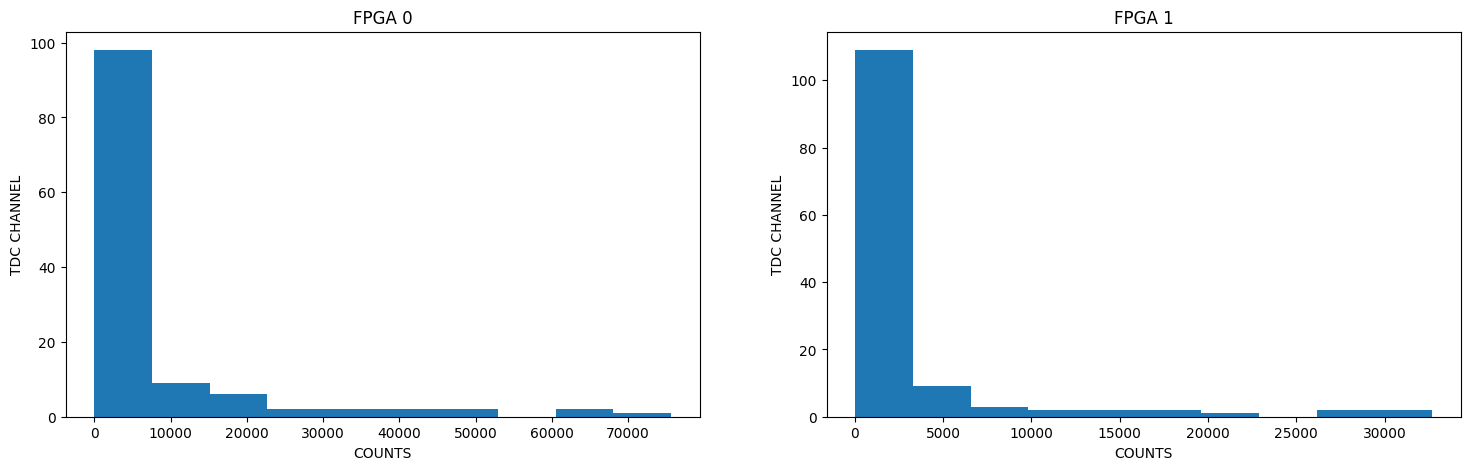

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.hist(FPGA0)
ax1.set_title('FPGA 0')
ax1.set_xlabel('COUNTS')
ax1.set_ylabel('TDC CHANNEL')

ax2.hist(FPGA1)
ax2.set_title('FPGA 1')
ax2.set_xlabel('COUNTS')
ax2.set_ylabel('TDC CHANNEL');